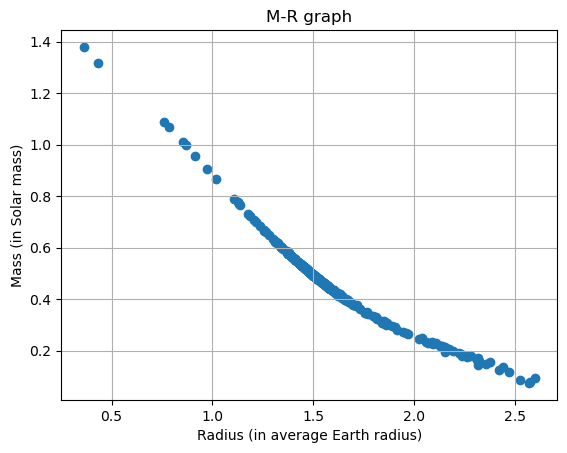

n* =  2.9586209437758764


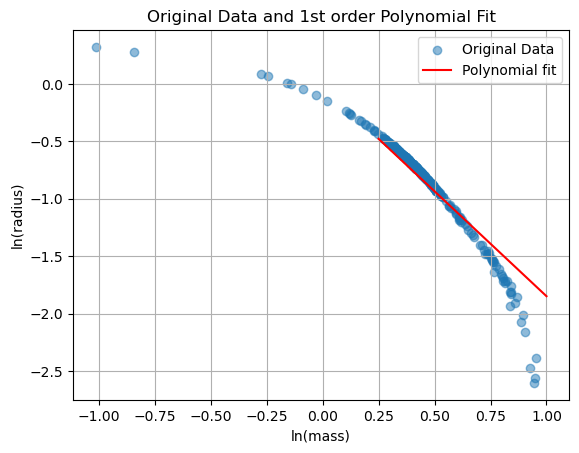

/tmp/ipykernel_42612/630062553.py:34: RuntimeWarning: invalid value encountered in scalar power
  d_fun[1] = (-fun[0]**1.5) - ( (2 / xi) * fun[1] )


Calculated Parameters:
θ	:	1.0176017680895436e-16
θ'	:	-0.202860682607365
ξ	:	3.6578223569228965
N	:	0.3013234291424712
K	:	0.04614137927671763
The K* value (scaled) is  0.11830253123884502  [Solar mass, Earth radius units]
The K* value (in MKS units) is  0.21598863459226803


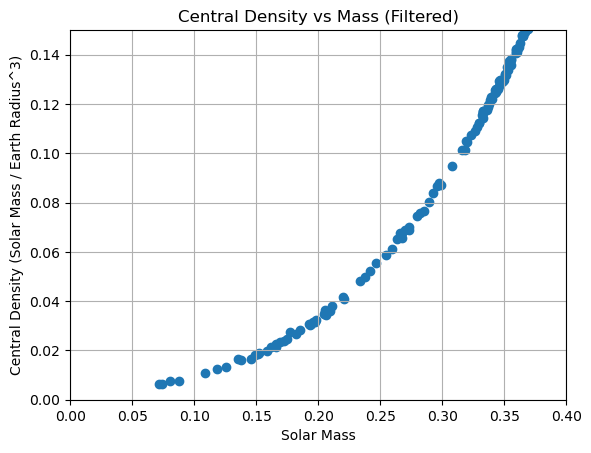

In [3]:
# PHYS414 - Final Project
# Question 1 - Newton
# Cem Cengiz Yazıcı
# 0076272
# cyazici20@ku.edu.tr

import csv
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt

def data_pars(FILE):
    # White Dwarf Data parser for the CSV file extension
    
    mass_list = []
    gravity_log10_list = []
    with open(FILE, 'r') as file:  # Always use `with` to open files
        reader = csv.reader(file, delimiter=',')
        next(reader)
        for a, b, c in reader:
            mass_list.append(float(b))
            gravity_log10_list.append(float(c))
    
    return np.array(gravity_log10_list), np.array(mass_list)

def lane_emden_equation(xi, fun):
    # Define Lane-Emden Eq'n in differential form
    
    d_fun = np.zeros(2) 
    if xi == 0:
        d_fun = np.array([0,1])
    else:
        d_fun[0] = fun[1]
        d_fun[1] = (-fun[0]**1.5) - ( (2 / xi) * fun[1] )
    
    return d_fun 


def mass_radii_filter(mass_list, radii, threshold):
    # Separates the mass and radius depending on the threshold, returns the data to include and exclude
    
    # Create a boolean mask to get the elements above threshold
    mask = radii > threshold  
    mass_list_filtered = np.array(np.log(mass_list[mask]))
    radii_filtered = np.array(np.log(radii[mask]))

    return mass_list_filtered, radii_filtered

def main():
    # Constants
    G = sci.constants.G
    g_solar = 1.9891 * 1e30 * G
    radii_earth = 6.3710088 * 10**6
    
    # Read White Dwarf Data and extract mass and log10(gravity) values
    FILE = "white_dwarf_data.csv"
    mass_list, gravity_log10_list = data_pars(FILE)
    
    N = len(mass_list)
    radii = [
        np.sqrt(g_solar * mass_list[i] / (10**(gravity_log10_list[i] - 2))) / radii_earth 
        for i in range(N)
    ]
    radii = np.array(radii)
    
    # Plot the resuts
    plt.scatter(radii, mass_list)
    plt.title('M-R graph')
    plt.xlabel('Radius (in average Earth radius)')
    plt.ylabel('Mass (in Solar mass)')
    plt.grid(True)
    plt.savefig("images_newton/1_M_vs_R_fitered.png")
    plt.show()
    
    # Part C
    # Constants
    mass_cutoff = 0.25
    mass_filtered, radii_filtered = mass_radii_filter(mass_list, radii, mass_cutoff)
    
    # Make 1st order Polynomial fit
    r_interval = np.linspace(mass_cutoff, 1.0, 400)
    coefs = np.polyfit(radii_filtered, mass_filtered, 1)
    polynomial_fit_values = np.polyval(coefs, r_interval)
    fit_slope = coefs[1]
    n_star = (fit_slope - 3)/(fit_slope - 1)
    print("n* = ", n_star)
    plt.figure()
    plt.title('Original Data and 1st order Polynomial Fit')
    plt.xlabel('ln(mass)')
    plt.ylabel('ln(radius)')
    plt.scatter(np.log(radii), np.log(mass_list), label='Original Data', alpha=0.5)
    plt.plot(r_interval, polynomial_fit_values, 'r', label='Polynomial fit', alpha=1)
    plt.legend()
    plt.grid(True)
    plt.savefig("images_newton/2_Polyfit.png")
    plt.show()
    
    # Use the results above to solve Lane-Emden Eq'n
    tolerance = 1e-15  # Tolerance
    xi = 2.45      # Initial guess
    theta = 1   # Initial Guess
    f0 = np.array([1, 0])
    max_iterations = 1e10
    n_iterations = 0
    while theta > tolerance:
        n_iterations += 1
        theta_solution = sci.integrate.solve_ivp(lane_emden_equation, t_span=[0, xi], y0 = f0, method = 'RK45')
        theta = theta_solution.y[0, -1]
        if theta > 0:
            xi = xi * 1.0001
        elif theta < 0:
            xi = xi * 0.9999
        elif n_iterations > max_iterations:
            raise("Maximum Iterations Reached. Stopping calculations.")
            break
        else:
            break
    
    
    # Calculate theta', N and K
    d_theta = theta_solution.y[1, -1]
    N = ((4*np.pi)**(1/n_star)/(n_star+1)) * (-xi**2 * d_theta)**((1-n_star)/n_star) * xi**((n_star-3)/n_star)
    K = np.exp(coefs[0] * ((n_star-1)/n_star)) * (g_solar/(radii_earth)**3) * N
    
    print("Calculated Parameters:")
    print("θ\t:\t" + str(theta))
    print("θ'\t:\t" + str(d_theta))
    print("ξ\t:\t" + str(xi))
    print("N\t:\t" + str(N))
    print("K\t:\t" + str(K))
    
    # sun_mass = 1.9891 * 1e30
    sun_mass    = g_solar/G      
    with np.errstate(invalid='ignore'): 
        grav_cons_scaled = G * sun_mass / (radii_earth**3)
    
        # K-value scaled w.r.t. solar mass and earth radius
        k_val = (4*np.pi*grav_cons_scaled/(2.5)) * np.power(np.exp(coefs[0] ) / (-4*np.pi*(xi**5)*d_theta), 1/3)
    
        # MKS equivalent of the K-value:
        k_val_mks = (4*np.pi*G/(2.5)) * np.power(np.exp(coefs[0]  + np.log(sun_mass) - coefs[1]*np.log(radii_earth)) / (-4*np.pi*(xi**5)*d_theta), 1/3)
    
    # Print out final calculations
    print('The K* value (scaled) is ', k_val, ' [Solar mass, Earth radius units]')
    print('The K* value (in MKS units) is ', k_val_mks)
    
    # Central density calculation from total mass equation:
    rho_c = - (mass_list * xi) / (4 * np.power(radii, 3) * d_theta * np.pi)
    
    # Plot the results
    plt.scatter(np.log(1+mass_list), np.log(1+rho_c))
    plt.ylabel('Central Density (Solar Mass / Earth Radius^3)')
    plt.xlabel('Solar Mass')
    plt.xlim([0, 0.40])
    plt.ylim([0, 0.15])
    plt.title('Central Density vs Mass (Filtered)')
    plt.grid(True)
    plt.savefig("images_newton/3_rhoc_vs_M.png")
    plt.show()

if __name__ == "__main__":
    main()
